## Семинар 10: "Генерация текстов"

ФИО: Калашников Дмитрий 

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2021-06-05 10:16:13--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  --.-KB/s    in 0.05s   

2021-06-05 10:16:13 (116 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
lines = [
    x.split('\t')[1].strip() ##!!!!!
    for x in open('author-quote.txt').readlines()
]
lines = [l.lower().replace(".", "").replace(",", "").replace("?", "").replace("!", "").replace("'", " ").split() for l in lines if l != ""]

In [4]:
lines[3]

['organizing',
 'is',
 'what',
 'you',
 'do',
 'before',
 'you',
 'do',
 'something',
 'so',
 'that',
 'when',
 'you',
 'do',
 'it',
 'it',
 'is',
 'not',
 'all',
 'mixed',
 'up']

In [6]:
[(len(l), l) for l in sorted(lines, key=len)][:50]

[(2, ['holy', 'cow']),
 (3, ['adventure', 'is', 'worthwhile']),
 (3, ['example', 'is', 'leadership']),
 (3, ['keep', 'it', 'simple']),
 (3, ['self-plagiarism', 'is', 'style']),
 (3, ['i', 'feel', 'old']),
 (3, ['i', 'expected', 'results']),
 (3, ['character', 'is', 'power']),
 (3, ['humor', 'is', 'healing']),
 (3, ['work', 'begets', 'work']),
 (3, ['make', 'haste', 'slowly']),
 (3, ['casseroles', 'are', 'one-pot-wonders']),
 (3, ['i', 'love', 'glee']),
 (3, ['o', 'mores', ')']),
 (3, ['elegance', 'is', 'refusal']),
 (3, ['self-realization', 'is', 'great']),
 (3, ['i', 'm', 'bisexual']),
 (3, ['politics', 'is', 'cyclical']),
 (3, ['i', 'am', 'reactive']),
 (3, ['humility', 'is', 'truth']),
 (3, ['i', 'became', 'stereotyped']),
 (3, ['always', 'educate', 'yourself']),
 (3, ['americans', 'never', 'quit']),
 (3, ['be', 'obscure', 'clearly']),
 (3, ['excellence', 'always', 'sells']),
 (3, ['racing', 'amuses', 'me']),
 (3, ['living', 'is', 'abnormal']),
 (3, ['forgotten', 'is', 'forgiven']),

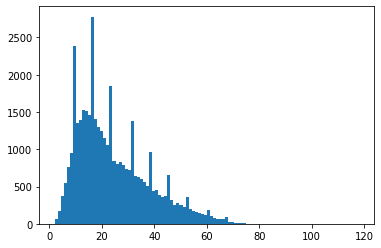

In [7]:
plt.hist(list(map(len, lines)), bins=100);

In [10]:
np.random.seed(777)
torch.manual_seed(777)

In [11]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [12]:
vocab = Vocabulary(lines)

In [13]:
len(lines)

39269

In [14]:
len(vocab.char_to_id)

32063

In [15]:
lines[0]

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [16]:
vocab.decode(vocab.encode(lines[0]))

'if you live to be a hundred i want to live to be a hundred minus one day so i never have to live without you'

In [17]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

AssertionError: ignored

In [18]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [19]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [20]:
dataset = Quotes(lines, vocab)

In [21]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=128,
    collate_fn=compose_batch)

In [22]:
import gensim.downloader

#w2v = gensim.downloader.load('word2vec-google-news-300')
w2v = gensim.downloader.load('glove-twitter-25')

matrix = []
for w_id in tqdm(range(len(vocab.id_to_char))):
     word = vocab.id_to_char[w_id]
     if word not in w2v:
       emb = w2v["_"]
     else:
       emb = w2v[word]

     matrix.append(emb)

[==================================================] 100.0% 104.8/104.8MB downloaded


In [23]:
w2v.most_similar("good")

[('too', 0.9648016095161438),
 ('day', 0.9533665180206299),
 ('well', 0.9503172039985657),
 ('nice', 0.9438973069190979),
 ('better', 0.9425961375236511),
 ('fun', 0.9418926239013672),
 ('much', 0.9413353204727173),
 ('this', 0.9387556314468384),
 ('hope', 0.9383507370948792),
 ('great', 0.9378515481948853)]

### Часть 2: определение модели

In [81]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super().__init__()

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line


class OracleW2V(Oracle):
    def __init__(self, embeddings,
                 hidden_size=256,                 
                 layers=2):    
        nn.Module.__init__(self)

        embedding_size = embeddings.shape[1]
        vocabulary_size = embeddings.shape[0]

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings))
        for param in self.embedding.parameters():
            param.requires_grad = False

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )

        self.project = nn.Linear(
            hidden_size, embedding_size
        )     

        self.classify = nn.Linear(
            embedding_size, vocabulary_size
        )

        self.classifier = nn.Sequential(self.project, self.classify)

        with torch.no_grad():
            self.classify.weight.copy_(torch.from_numpy(embeddings))
        self.classify.weight.requires_grad = False

In [33]:
oracle = OracleW2V(np.array(matrix), hidden_size=64)

In [26]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

### Часть 3: обучение модели

In [34]:
#optimizer = torch.optim.RMSprop(
#    oracle.parameters(), lr=0.001, weight_decay=1e-5
#)

optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01)

In [35]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [36]:
losses = []

In [37]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

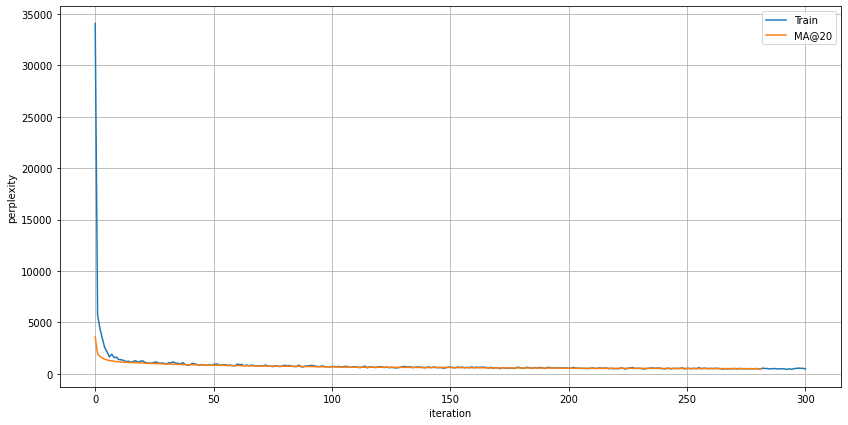

In [38]:
oracle.cuda()

for epoch in range(1):
    bar = progressbar.ProgressBar()
    for i, batch in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()

        #[x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.requires_grad]

        optimizer.step()      

        losses.append(np.exp(loss.cpu().item()))

        if i % 50 == 0:
            clear_output(True)
            plt.figure(figsize=(14,7))
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [32]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


and that get real progressive <eos> 
is if be <eos> 
a when i like to define advance the on martin heart the the has about better very under crown survive 
the to artistry i as to stories come learn everyday those if for ve it the <eos> 
came in by all consists no are annual no out think does; can chosen it the seems they tech <eos> 
my when in having slightly i an i them blues remember christian to <eos> 
learning one it two sober partner moonlight will what the rock able each i up day that ll enough s of 
of windshield from soul to are something will little hadn people at <eos> 
you one descended very <eos> 
between a feed think for the wanted stabbed his been <eos> 
utopia you when people am pieces to in all moderate a but a i comedian and s fortune re i can a really 
are ourselves artist way us <eos> 
you that work always become expanded gifts follow the a the am might at he or learn lot female am to 
that attachment wanting don <eos> 
i to you despite show it having anything touch

In [40]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


i quite see time being since and so work to if nothin and but long that never he you ever a mature the 
a you is getting two the moments the age of cafeteria before in the mythology of sixth good green than 
no women different books used world even to drank many under with plants white anchorage and pole in 
time is is a needy wants dover; an low appreciated in if lies of son now: truth allah growth: weakness 
light ends of happiness god abba: have matter the communication in of ass pollution policy: afterwards 
i be when both were where s a thing you always its t are more than still something to make into the 
just going a confusing conversation is get the true and look an solitude the addition the great the 
that knows a when that to do not never that one done oversight i bitterly up it world has feeling rejection 
we or the low success and man a muscles on family them that un gives the fetish would or back defend 
me s spiritual was have biological religious body the good enhancing 

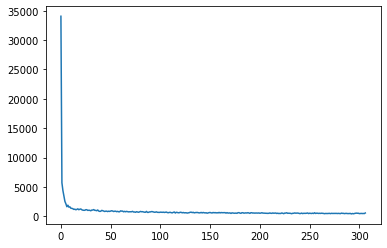

In [41]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [96]:
train_dataset = Quotes(lines[:35000], vocab)
test_dataset = Quotes(lines[35000:], vocab)

train_dataloader = DataLoader(
    train_dataset, shuffle=True,
    batch_size=128,
    collate_fn=compose_batch)

test_dataloader = DataLoader(
    test_dataset, shuffle=True,
    batch_size=128,
    collate_fn=compose_batch)

In [196]:
class OracleLSTM(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super().__init__()

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        c = torch.zeros(self.layers, 1, self.hidden_size)

        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h, c) = self.generator(embedding, (h, c))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

class OracleW2VLSTM(OracleLSTM):
    def __init__(self, embeddings,
                 hidden_size=256,                 
                 layers=2):    
        nn.Module.__init__(self)

        embedding_size = embeddings.shape[1]
        vocabulary_size = embeddings.shape[0]

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings))
        for param in self.embedding.parameters():
            param.requires_grad = False

        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )

        self.project = nn.Linear(
            hidden_size, embedding_size
        )     

        self.classify = nn.Linear(
            embedding_size, vocabulary_size
        )

        self.classifier = nn.Sequential(self.project, self.classify)

        with torch.no_grad():
            self.classify.weight.copy_(torch.from_numpy(embeddings))
        self.classify.weight.requires_grad = False

In [197]:
def train():
    oracle.cuda()

    optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss(reduction='none')
    train_losses = []
    test_losses = []

    for epoch in range(5):

        losses = []

        oracle.train()
        for i, train_batch in enumerate( train_dataloader ):

            go, eos, mask, length = train_batch
            go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

            oracle.zero_grad()
            prediction = oracle(
                go, length
            ).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos)*mask.float()).sum()
            loss = loss / mask.sum()
            loss.backward()

            #[x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.requires_grad]

            optimizer.step()      
            losses.append(np.exp(loss.cpu().item()))

        train_losses.append(np.mean(losses))

        losses = []

        oracle.eval()
        with torch.no_grad():
            for i, test_batch in enumerate( test_dataloader ):

                    go, eos, mask, length = test_batch
                    go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

                    prediction = oracle(
                        go, length
                    ).transpose(0, 1).transpose(1, 2)
                    loss = (criterion(prediction, eos)*mask.float()).sum()
                    loss = loss / mask.sum()  

                    losses.append(np.exp(loss.cpu().item()))

        test_losses.append(np.mean(losses))

        verbose = True
        if verbose:

            clear_output(True)
            print('\rEpoch {0}... (Train/Test) Perplexity: {1:.3f}/{2:.3f}'.format(
                        epoch, train_losses[-1], test_losses[-1]))
            plt.figure(figsize=(14, 7))

            plt.plot(train_losses, label='Train')
            plt.plot(test_losses, label='Test')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

    return losses

In [198]:
oracle = OracleW2VLSTM(np.array(matrix), hidden_size=16)

Epoch 4... (Train/Test) Perplexity: 395.299/459.007


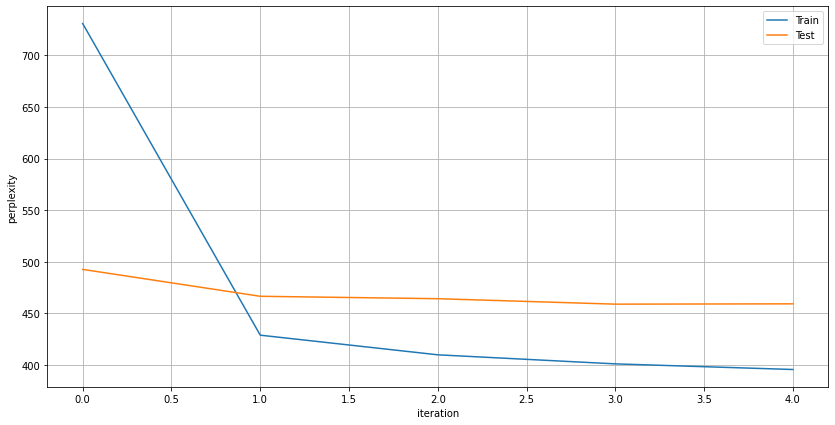

In [199]:
losses = train()

In [115]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


i <eos> 
to be doing great commitment in the s destination is more grateful provide <eos> 
i rather an industry teach front our reproduction consumes the books you think it movement she t a not 
world is without the <eos> 
it s a relaxed very thoughtful family do but if if me know us me the <eos> 
the s of a part way you power yourself and fundamentally part of does life it s the dramatic climate 
of your their european that that burning to tempering it will be <eos> 
into all hatred schools is on this ability with than belief and war in a emotional cancer with fidelity 
for a the break it s hardest to sleep to someone it s going to sit off leave around to but this business 
swim the star great country were the world could every a summer for a every at things are not lessons 
existence is have in sense it s shocking zarqawi to learn the if how means you remember it s a human 
have just had of national matter to i such it in the the the fall yet i never both david acting hundredths 
i g

### Гиперпараметры

In [140]:
torch.cuda.empty_cache()

In [141]:
train_dataset = Quotes(lines[:35000], vocab)
test_dataset = Quotes(lines[35000:], vocab)

train_dataloader = DataLoader(
    train_dataset, shuffle=True,
    batch_size=32,
    collate_fn=compose_batch)

test_dataloader = DataLoader(
    test_dataset, shuffle=True,
    batch_size=32,
    collate_fn=compose_batch)

In [155]:
def train(lr, verbose=False):
    oracle.cuda()

    optimizer = torch.optim.AdamW(oracle.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction='none')
    train_losses = []
    test_losses = []

    for epoch in range(3):

        
        for i, (train_batch, test_batch) in enumerate( zip(train_dataloader, test_dataloader) ):

            oracle.train()
            
            go, eos, mask, length = train_batch
            go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

            oracle.zero_grad()
            prediction = oracle(
                go, length
            ).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos)*mask.float()).sum()
            loss = loss / mask.sum()
            loss.backward()

            #[x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.requires_grad]

            optimizer.step()      
            train_losses.append(np.exp(loss.cpu().item()))

            oracle.eval()
            with torch.no_grad():

                go, eos, mask, length = test_batch
                go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

                prediction = oracle(
                    go, length
                ).transpose(0, 1).transpose(1, 2)
                loss = (criterion(prediction, eos)*mask.float()).sum()
                loss = loss / mask.sum()  

                test_losses.append(np.exp(loss.cpu().item()))

                if verbose and i % 50 == 0:

                    if epoch == 0 and i == 50:
                        train_losses = []
                        test_losses = []
                        continue

                    clear_output(True)
                    print('\rEpoch {0}... (Train/Test) Perplexity: {1:.3f}/{2:.3f}'.format(
                                epoch, train_losses[-1], test_losses[-1]))
                    plt.figure(figsize=(14, 7))

                    plt.plot(train_losses, label='Train')
                    plt.plot(test_losses, label='Test')
                    plt.xlabel('iteration')
                    plt.ylabel('perplexity')
                    plt.legend()
                    plt.grid()
                    plt.show()

    return test_losses

Epoch 2... (Train/Test) Perplexity: 471.579/478.509


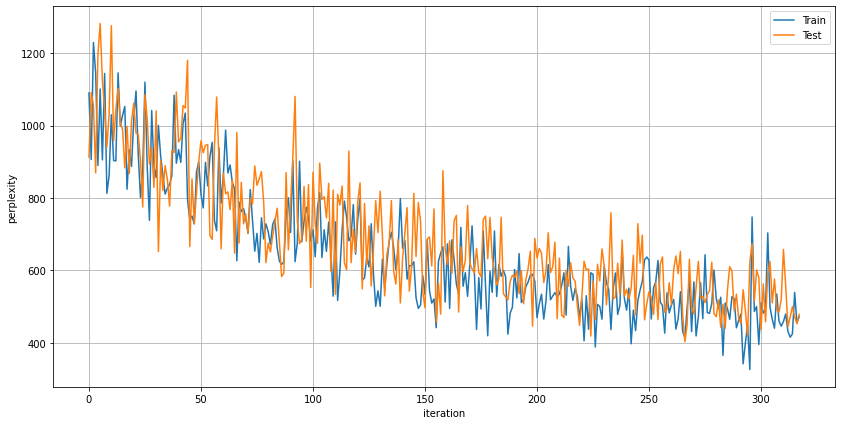

In [154]:
oracle = OracleW2VLSTM(np.array(matrix), hidden_size=64, layers=2)
test_losses = train(lr=0.01, verbose=1)

In [188]:
import itertools
losses = []
all_params = list(itertools.product( [64, 128, 256,], [1, 2, 3], [1e-4, 1e-3, 0.01, 0.05]))

for hidden_size, layers, lr in tqdm( all_params ):
    oracle = OracleW2VLSTM(np.array(matrix), hidden_size=hidden_size, layers=layers)
    test_losses = train(lr=lr)
    losses.append(test_losses)

Perplexity: 348.0749902770357 - hidden_size=128, layers=1, lr=0.05


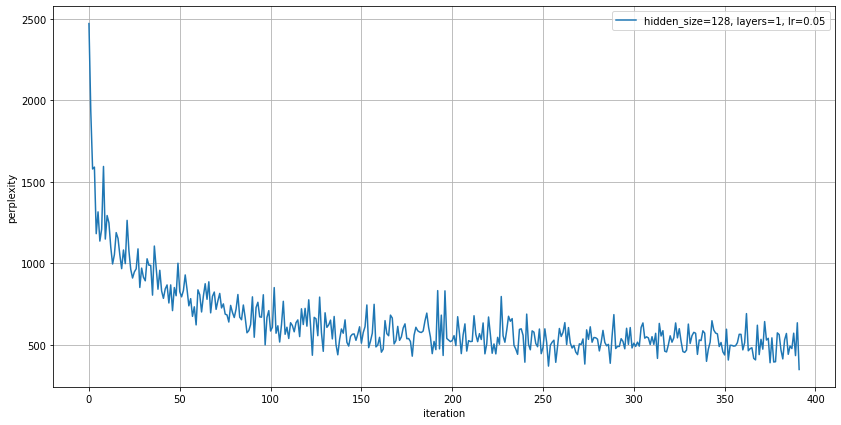

In [190]:
plt.figure(figsize=(14,7))
ind = np.argmin( np.array(losses), axis=0 )[-1]
loss = losses[ ind ]
params = all_params[ ind ]
plt.plot(loss[10:], label=f'hidden_size={params[0]}, layers={params[1]}, lr={params[2]}')
plt.xlabel('iteration')
plt.ylabel('perplexity')
print( f'Perplexity: {loss[-1]} - hidden_size={params[0]}, layers={params[1]}, lr={params[2]}' )
plt.legend()
plt.grid()
plt.show()

Итого: perplexity 348 vs 478

Для оценки масштаба:

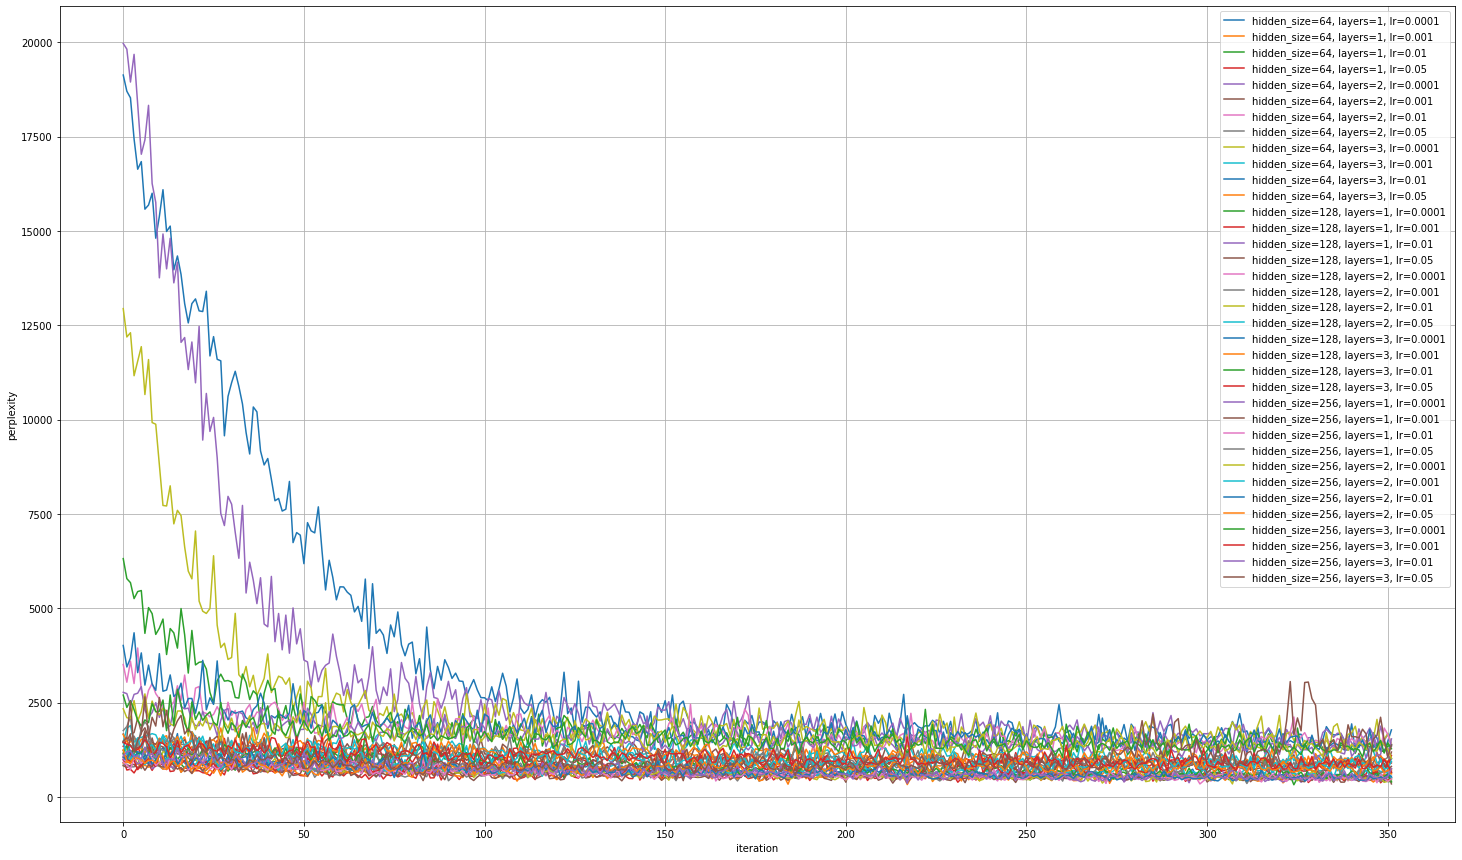

In [195]:
plt.figure(figsize=(25,15))
for loss, params in zip(losses, all_params):
    plt.plot(loss[50:], label=f'hidden_size={params[0]}, layers={params[1]}, lr={params[2]}')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
plt.legend()
plt.grid()
plt.show()